<a href="https://colab.research.google.com/github/Aditya-Patel/Stat598-FinalProject/blob/main/MPLA_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# Dataset
import yfinance as yf

# Visualization
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
mpl.rcParams['figure.dpi'] = 125
mpl.rcParams['figure.figsize'] = (10, 5)

# Date Manipulation
from datetime import datetime

# PyTorch Libraries
import tensorflow as tf
from tensorflow import keras

# statstical testing, plotting and decompositions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Set device usage to GPU if available
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
device = tf.device('/device:gpu:1')

In [66]:
# Neural Network Constants
TRAINING_EPOCHS = 2000
BATCH_SIZE = 16
NEURON_CT = 128
POOL_SZ = 5
STRIDES = 1

In [67]:
start_date = '2020-06-01'
end_date = '2023-12-01'
etf_ticker = 'MLPA'
moving_average_list = []
etf_tickers_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/mlpa_full-holdings.csv"
crude_oil_stock_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/crude%20oil%20spot%20price.csv"

<h1>Create joint dataset between spot price and ETF Data</h1>

In [68]:
df_holdings = pd.read_csv(etf_tickers_url)
df_holdings = df_holdings[(df_holdings['Name'] != 'OTHER PAYABLE & RECEIVABLES') & (df_holdings['Name'] != 'CASH')]
df_holdings[f'Market Value ($)'] = df_holdings[f'Market Value ($)'].str.replace(',', '').astype(float)
total_market_value = df_holdings[f'Market Value ($)'].sum()
df_holdings['Percentage Holdings By Value'] = (df_holdings[f'Market Value ($)'] / total_market_value)

df_crude_price = pd.read_csv(crude_oil_stock_url,usecols=[0, 1])
df_crude_price['Date'] = pd.to_datetime(df_crude_price['Date'], format='%b %d, %Y')
df_crude_price.set_index('Date', inplace=True)
df_crude_price.rename(columns={'WTI Barrell Spot Price':'Spot Price'}, inplace=True)
df_crude_price['Spot Price'] = df_crude_price['Spot Price'].fillna(method='ffill')

all_stocks_data = yf.download(etf_ticker, start=start_date, end=end_date)

# Join spot price and etf data
all_stocks_data['Ticker'] = etf_ticker
all_stocks_data.columns = [f'{etf_ticker}_{col}' if col not in ['Ticker', 'Date'] else col for col in all_stocks_data.columns]
all_stocks_data = all_stocks_data.join(df_crude_price, how='left')

[*********************100%%**********************]  1 of 1 completed


<h1>Load all tickers within the ETF</h1>

In [69]:
# load all tickers part of that etf
for ticker in df_holdings['Ticker']:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    percentage_holding = df_holdings.loc[df_holdings['Ticker'] == ticker, 'Percentage Holdings By Value'].iloc[0]
    all_stocks_data[f'{ticker}_Percent_Holding'] = percentage_holding
    stock_data.columns = [f'{ticker}_{col}' if col != 'Ticker' else col for col in stock_data.columns]
    all_stocks_data = all_stocks_data.join(stock_data, how='outer')

all_stocks_data.fillna(0, inplace=True)
sum_values = pd.Series(0, index=all_stocks_data.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [70]:
# Get all closing values

all_stocks_data[f'{etf_ticker}_Next_Close'] = all_stocks_data[f'{etf_ticker}_Close'].shift(-1)
all_stocks_data = all_stocks_data.drop(all_stocks_data.index[-1])
close_values = all_stocks_data[[col for col in all_stocks_data.columns if '_Close' in col or col == 'Spot Price' or col == f'{etf_ticker}_Next_Close']]


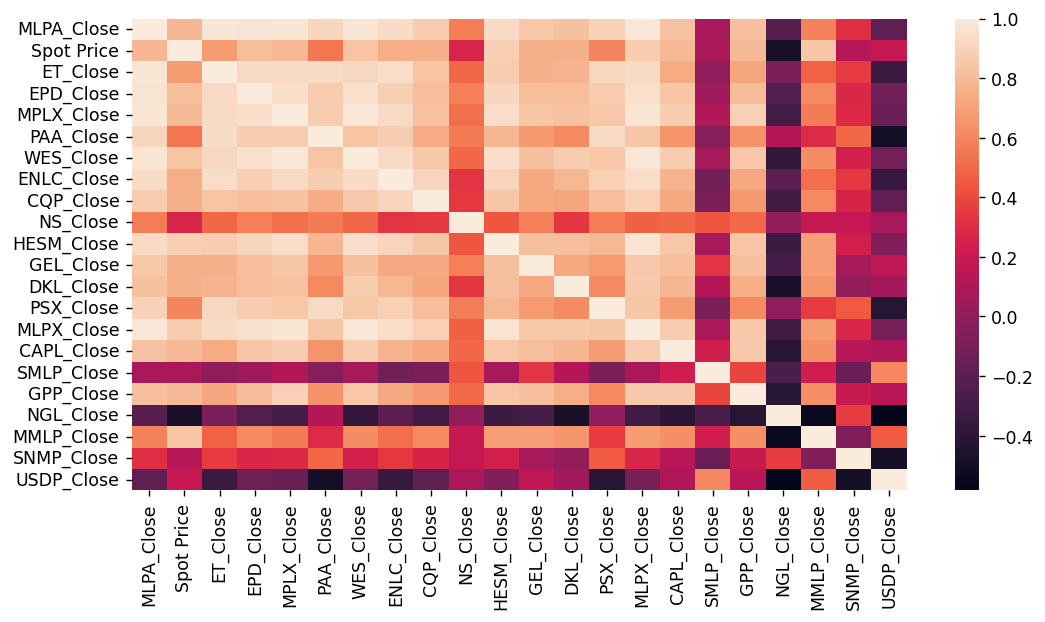

In [71]:
# Check correlation
df = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])
sns.heatmap(df.corr(), annot=False)
plt.show()

Based on the plot of the correlation matrix, we see that most of the stocks are correlated positively with each other with the exception of SMLP, NGL and USDP, which have negative correlation. We expect to see this as a good ETF consists of a variety of tickers to protect against large market swings either way.

<h1>Model Development<h1>
<h2> A Dense Neural Network is developed in TensorFlow to perform future analysis based on the previous closing price trend. <h2>

In [72]:
# Generate X and y input datasets - Since we are predicting the next day value, we use the 'Next_Close' as the target value
y = close_values[f'{etf_ticker}_Next_Close']
X = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

In [73]:
# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)

# Convert to tensors and prefetch
train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_df = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_df = train_df.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [74]:
# CNN - 3 Convolution Layers, 3 Dense Layers
model_1 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/2, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(1)
])

model_1.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 20, 32)            128       
                                                                 
 max_pooling1d_26 (MaxPooli  (None, 16, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 14, 64)            6208      
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 8, 128)            24704     
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 4, 128)           

In [76]:
# CNN 1- 2 Convolution Layers, 4 Dense Layers
model_2 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(NEURON_CT/4, activation='relu'),
    keras.layers.Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')

In [77]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 20, 32)            128       
                                                                 
 max_pooling1d_29 (MaxPooli  (None, 16, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_31 (Conv1D)          (None, 14, 128)           12416     
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 10, 128)           0         
 ng1D)                                                           
                                                                 
 dense_30 (Dense)            (None, 10, 128)           16512     
                                                                 
 dense_31 (Dense)            (None, 10, 64)          

In [78]:
# CNN 1- 4 Convolution Layers, 2 Dense Layers
model_3 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/8, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/2, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    # keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(1)
])

model_3.compile(optimizer='adam', loss='mean_squared_error')

In [79]:
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 20, 16)            64        
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 16, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_33 (Conv1D)          (None, 14, 32)            1568      
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 10, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_34 (Conv1D)          (None, 8, 64)             6208      
                                                                 
 max_pooling1d_33 (MaxPooli  (None, 4, 64)           

In [ ]:
# CNN - 1 Convolution Layers, 3 Dense Layers
model_4 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(1)
])

model_4.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)    

In [80]:
# Fit model to training data with 20% validation split
model_1.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            callbacks = [lr_reducer],
            validation_split = 0.2)

Epoch 1/2000
27/27 [==============================] - 1s 9ms/step - loss: 137.8101 - val_loss: 9.3965
Epoch 2/2000
27/27 [==============================] - 0s 5ms/step - loss: 10.2348 - val_loss: 6.1860
Epoch 3/2000
27/27 [==============================] - 0s 4ms/step - loss: 6.2533 - val_loss: 5.4175
Epoch 4/2000
27/27 [==============================] - 0s 4ms/step - loss: 4.5583 - val_loss: 3.8866
Epoch 5/2000
27/27 [==============================] - 0s 3ms/step - loss: 3.4233 - val_loss: 2.9914
Epoch 6/2000
27/27 [==============================] - 0s 4ms/step - loss: 2.8490 - val_loss: 2.6083
Epoch 7/2000
27/27 [==============================] - 0s 4ms/step - loss: 2.6925 - val_loss: 1.9417
Epoch 8/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.3688 - val_loss: 1.8372
Epoch 9/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.2680 - val_loss: 1.7910
Epoch 10/2000
27/27 [==============================] - 0s 5ms/step - loss: 1.9835 - val_loss: 1.6

In [81]:

model_2.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            callbacks = [lr_reducer],
            validation_split = 0.2)

Epoch 1/2000
27/27 [==============================] - 0s 5ms/step - loss: 169.1322 - val_loss: 34.3252
Epoch 2/2000
27/27 [==============================] - 0s 2ms/step - loss: 27.2359 - val_loss: 14.4960
Epoch 3/2000
27/27 [==============================] - 0s 2ms/step - loss: 9.6784 - val_loss: 9.5294
Epoch 4/2000
27/27 [==============================] - 0s 2ms/step - loss: 6.0321 - val_loss: 4.7813
Epoch 5/2000
27/27 [==============================] - 0s 2ms/step - loss: 4.7282 - val_loss: 3.8514
Epoch 6/2000
27/27 [==============================] - 0s 2ms/step - loss: 4.3248 - val_loss: 4.5554
Epoch 7/2000
27/27 [==============================] - 0s 2ms/step - loss: 3.8906 - val_loss: 3.2001
Epoch 8/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.7269 - val_loss: 2.4289
Epoch 9/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.4131 - val_loss: 2.6411
Epoch 10/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.4975 - val_loss: 1

In [82]:
model_3.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            callbacks = [lr_reducer],
            validation_split = 0.2)

Epoch 1/2000
27/27 [==============================] - 1s 6ms/step - loss: 204.7444 - val_loss: 24.3643
Epoch 2/2000
27/27 [==============================] - 0s 2ms/step - loss: 17.9081 - val_loss: 14.4404
Epoch 3/2000
27/27 [==============================] - 0s 2ms/step - loss: 10.0234 - val_loss: 8.8817
Epoch 4/2000
27/27 [==============================] - 0s 2ms/step - loss: 6.9649 - val_loss: 7.7504
Epoch 5/2000
27/27 [==============================] - 0s 2ms/step - loss: 5.0271 - val_loss: 3.8643
Epoch 6/2000
27/27 [==============================] - 0s 2ms/step - loss: 3.4665 - val_loss: 2.9297
Epoch 7/2000
27/27 [==============================] - 0s 4ms/step - loss: 3.0427 - val_loss: 2.8938
Epoch 8/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.8187 - val_loss: 2.7127
Epoch 9/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.5591 - val_loss: 3.1141
Epoch 10/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.5428 - val_loss: 

In [ ]:
model_4.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            callbacks = [lr_reducer],
            validation_split = 0.2)

In [83]:
# Predict next close with all models
y1_pred = [val[0] for val in [val[0] for val in model_1.predict(X_test)]]
mse1 = mean_squared_error(y1_pred, y_test)


y2_pred = [val[0] for val in [val[0] for val in model_2.predict(X_test)]]
mse2 = mean_squared_error(y2_pred, y_test)


y3_pred = [val[0] for val in [val[0] for val in model_3.predict(X_test)]]
mse3 = mean_squared_error(y3_pred, y_test)

12/12 [==============================] - 0s 767us/step


In [84]:
results_df = pd.DataFrame(y_test)
results_df['y1_pred'] = y1_pred
results_df['y2_pred'] = y2_pred
results_df['y3_pred'] = y3_pred
results_df.columns = ['y_actual', 'y1_pred', 'y2_pred', 'y3_pred']
results_df.sort_index(inplace=True)


In [85]:
print(f'Hyperparameters: [Training Epochs: {TRAINING_EPOCHS} || Batch Size: {BATCH_SIZE} || Neurons: {NEURON_CT}]')
print(f'Price forecast: model_1: MSE: {mse1:.4f}')
print(f'Price forecast: model_2: MSE: {mse2:.4f}')
print(f'Price forecast: model_3: MSE: {mse3:.4f}')


Hyperparameters: [Training Epochs: 2000 || Batch Size: 16 || Neurons: 128]
Price forecast: model_1: MSE: 0.4882
Price forecast: model_2: MSE: 0.5013
Price forecast: model_3: MSE: 0.5453


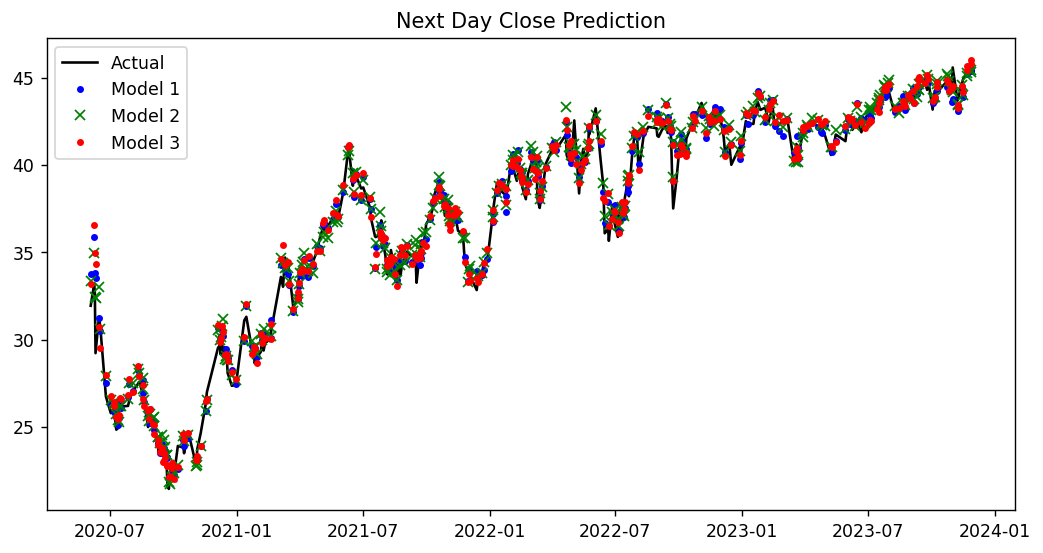

In [86]:
x = [x for x in range(len(y_test))]
plt.plot(results_df.y_actual, 'k', label='Actual')
plt.plot(results_df.y1_pred, '.b', label='Model 1')
plt.plot(results_df.y2_pred, 'xg', label='Model 2')
plt.plot(results_df.y3_pred, '.r', label='Model 3')
plt.title('Next Day Close Prediction')
plt.legend()
plt.show()

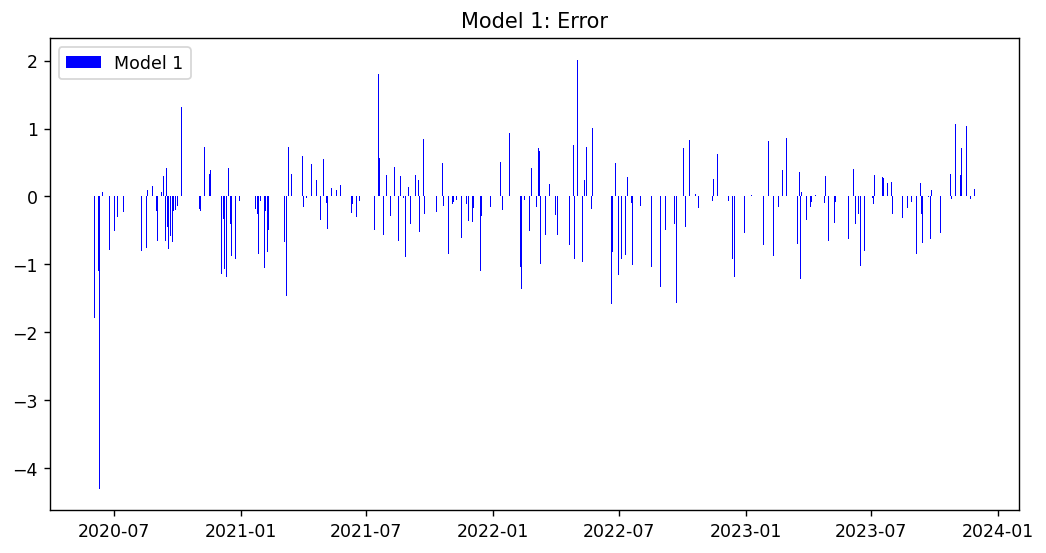

In [87]:
y1_diff = results_df.y_actual - results_df.y1_pred
y2_diff = results_df.y_actual - results_df.y2_pred
y3_diff = results_df.y_actual - results_df.y3_pred

plt.bar(results_df.index, y1_diff, color='blue', label='Model 1')
plt.title('Model 1: Error')
plt.legend()
plt.show()

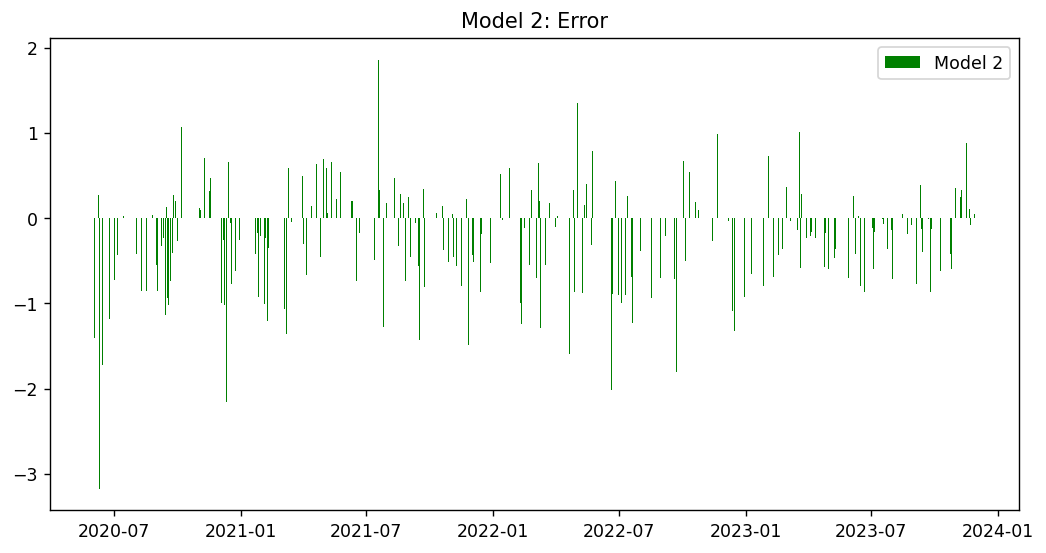

In [88]:
plt.bar(results_df.index, y2_diff, color='green', label='Model 2')
plt.title('Model 2: Error')
plt.legend()
plt.show()

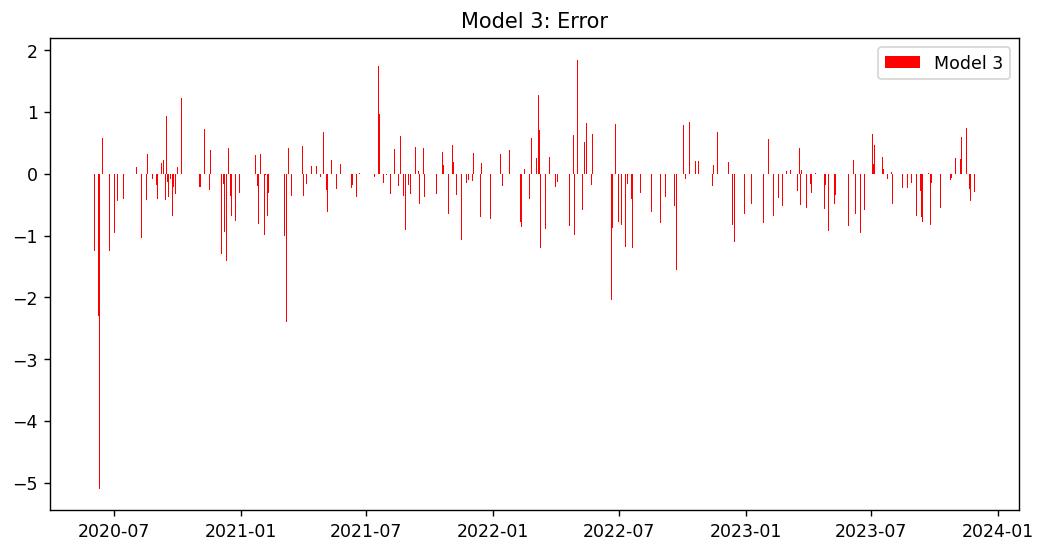

In [89]:
plt.bar(results_df.index, y3_diff, color='red', label='Model 3')
plt.title('Model 3: Error')
plt.legend()
plt.show()